# Project 1: Option Hedging Project (Python)

Keonhi Lee

March 22, 2021

# 1. Load a json file. (histfile.json)

In [1]:
import json
import pandas as pd
import numpy as np
from scipy.stats import norm
from datetime import timedelta

In [2]:
histfile = open('histfile.json')
data = json.load(histfile)
histfile.close()

In [3]:
tickers=data.keys()
price_history=pd.DataFrame()

In [4]:
for ticker in tickers:
    price_history=\
    pd.concat((price_history, pd.Series(data=data[ticker]['Price'], index=data[ticker]['Date']).rename(ticker)), axis=1)
price_history.index=pd.to_datetime(price_history.index)

In [5]:
price_history

,AAPL US Equity,JPM US Equity,WMT US Equity
2019-11-01,255.82,127.80,117.62
2019-11-04,257.50,128.82,117.57
2019-11-05,257.13,129.10,118.86
2019-11-06,257.24,129.30,119.50
2019-11-07,259.43,130.00,120.23
...,...,...,...
2020-01-27,308.95,132.03,115.86
2020-01-28,317.69,134.43,116.60
2020-01-29,324.34,134.23,115.89
2020-01-30,323.87,135.89,116.58


# 2. Write a function to price and calculate delta on European option using Black-Scholes Formula.

In [6]:
def vanilla_opt(S, K, T, r, v, q, opt_type):
    d1=(np.log(S/K)+(r-q+1/2*v**2)*T)/v*np.sqrt(T)
    d2=d1-v*np.sqrt(T)
    if opt_type=='Call':
        return S*np.exp(-q*T)*norm.cdf(d1)-K*np.exp(-r*T)*norm.cdf(d2)
    elif opt_type=='Put':
        return -S*np.exp(-q*T)*norm.cdf(-d1)+K*np.exp(-r*T)*norm.cdf(-d2)
    else:
        print('Option type is incorrect.')

In [7]:
def vanilla_delta(S, K, T, r, v, q, opt_type):
    d1=(np.log(S/K)+(r-q+1/2*v**2)*T)/v*np.sqrt(T)
    if opt_type=='Call':
        return np.exp(-q*T)*norm.cdf(d1)
    elif opt_type=='Put':
        return -np.exp(-q*T)*norm.cdf(-d1)
    else:
        print('Option type is incorrect.')

# 3. Do a historical simulation of delta hedging strategy.

Act/365 is used as the day count convention for calculating option price and option delta.

Act/360 is used as the day count convention for calculating overnight interest on cash balance with simple linear compounding .

In [8]:
def simplified_dynamic_delta_hedge(price_history_df, num_opt, K, r, v, q, opt_type, instrument_delta=1, target_delta=0):
    
    # create a dateframe of delta hedge
    dynamic_delta_hedge_df=pd.DataFrame(index=price_history_df.index,\
                                        columns=['New Stock Price', 'New Option Delta', 'Current Option Position',\
                                                 'New Stock Delta', 'Current Stock Position',\
                                                 'Portfolio Delta Before Hedge', 'Target Portfolio Delta',\
                                                 'Required Change in Stock Position', 'Cash Balance'])
    dynamic_delta_hedge_df['New Stock Price']=price_history_df
    dynamic_delta_hedge_df['Current Option Position']=num_opt
    dynamic_delta_hedge_df['New Stock Delta']=instrument_delta
    dynamic_delta_hedge_df['Target Portfolio Delta']=target_delta
    
    # calculate initial option price
    initial_day=price_history.index[0]
    maturity_day=price_history.index[-1]
    opt_price=vanilla_opt(S=price_history_df.iloc[0], K=K, T=(maturity_day-initial_day).days/365, r=r, v=v, q=q, opt_type=opt_type)
    
    # create a dummy row for initialization
    dummy_day=initial_day-timedelta(days=1)
    dynamic_delta_hedge_df.loc[dummy_day, ['Current Stock Position', 'Required Change in Stock Position']]=0
    dynamic_delta_hedge_df.loc[dummy_day, 'Cash Balance']=-opt_price*num_opt
    
    # conduct delta hedge
    for day in price_history_df.index:
        previous_day=dynamic_delta_hedge_df.index[list(price_history_df.index).index(day)-1]
        
        dynamic_delta_hedge_df.loc[day, 'New Option Delta']=\
        vanilla_delta(S=dynamic_delta_hedge_df.loc[day, 'New Stock Price'], K=K, T=(maturity_day-day).days/365, r=r, v=v, q=q, opt_type=opt_type)
        
        dynamic_delta_hedge_df.loc[day, 'Current Stock Position']=\
        dynamic_delta_hedge_df.loc[previous_day, 'Current Stock Position']+dynamic_delta_hedge_df.loc[previous_day, 'Required Change in Stock Position']
        
        dynamic_delta_hedge_df.loc[day, 'Portfolio Delta Before Hedge']=\
        dynamic_delta_hedge_df.loc[day, 'New Option Delta']*dynamic_delta_hedge_df.loc[day, 'Current Option Position']\
        +dynamic_delta_hedge_df.loc[day, 'New Stock Delta']*dynamic_delta_hedge_df.loc[day, 'Current Stock Position']
        
        if day == maturity_day:
            dynamic_delta_hedge_df.loc[day, 'Target Portfolio Delta']=dynamic_delta_hedge_df.loc[day, 'Portfolio Delta Before Hedge']
        
        dynamic_delta_hedge_df.loc[day, 'Required Change in Stock Position']=\
        (dynamic_delta_hedge_df.loc[day, 'Target Portfolio Delta']-dynamic_delta_hedge_df.loc[day, 'Portfolio Delta Before Hedge'])\
        /dynamic_delta_hedge_df.loc[day, 'New Stock Delta']
        
        dynamic_delta_hedge_df.loc[day, 'Cash Balance']=\
        dynamic_delta_hedge_df.loc[previous_day, 'Cash Balance']\
        -dynamic_delta_hedge_df.loc[day, 'Required Change in Stock Position']*dynamic_delta_hedge_df.loc[day, 'New Stock Price']

    # delete the dummy row
    dynamic_delta_hedge_df=dynamic_delta_hedge_df.drop(index=dummy_day)
    
    # execute right
    if opt_type=='Call':
        execution=max(price_history_df.iloc[-1]-K, 0)
    elif opt_type=='Put':
        execution=max(K-price_history_df.iloc[-1], 0)
    else:
        print('Option type is incorrect.')
    
    # calculate pnl
    pnl=\
    dynamic_delta_hedge_df.loc[maturity_day, 'Current Stock Position']*dynamic_delta_hedge_df.loc[maturity_day, 'New Stock Price']\
    +dynamic_delta_hedge_df.loc[maturity_day, 'Cash Balance']+execution*num_opt
    
    return dynamic_delta_hedge_df, pnl, opt_price

In [9]:
pnl_simplified={}
opt_price={}

In [10]:
for ticker in tickers:
    df, pnl_simplified[ticker], opt_price[ticker] = \
    simplified_dynamic_delta_hedge(price_history_df=price_history[ticker], num_opt=100, K=price_history[ticker].iloc[0], r=0.02,\
                                   v=data[ticker]['Volatility'], q=data[ticker]['Dividend'], opt_type='Call', instrument_delta=1, target_delta=0)
    print(ticker)
    display(df)
    print('\n')

AAPL US Equity


,New Stock Price,New Option Delta,Current Option Position,New Stock Delta,Current Stock Position,Portfolio Delta Before Hedge,Target Portfolio Delta,Required Change in Stock Position,Cash Balance
2019-11-01,255.82,0.506845,100.0,1.0,0,50.6845,0.000000,-50.6845,11693.350505
2019-11-04,257.50,0.511709,100.0,1.0,-50.6845,0.486404,0.000000,-0.486404,11818.599521
2019-11-05,257.13,0.510423,100.0,1.0,-51.170904,-0.12863,0.000000,0.12863,11785.524853
2019-11-06,257.24,0.510621,100.0,1.0,-51.042274,0.019778,0.000000,-0.019778,11790.612567
2019-11-07,259.43,0.517121,100.0,1.0,-51.062052,0.650052,0.000000,-0.650052,11959.255604
...,...,...,...,...,...,...,...,...,...
2020-01-27,308.95,0.532148,100.0,1.0,-54.922472,-1.707626,0.000000,1.707626,12264.376249
2020-01-28,317.69,0.531946,100.0,1.0,-53.214846,-0.020225,0.000000,0.020225,12257.951046
2020-01-29,324.34,0.528578,100.0,1.0,-53.194621,-0.336819,0.000000,0.336819,12148.707251
2020-01-30,323.87,0.52009,100.0,1.0,-52.857802,-0.848817,0.000000,0.848817,11873.800958




JPM US Equity


,New Stock Price,New Option Delta,Current Option Position,New Stock Delta,Current Stock Position,Portfolio Delta Before Hedge,Target Portfolio Delta,Required Change in Stock Position,Cash Balance
2019-11-01,127.80,0.500204,100.0,1.0,0,50.020407,0.00000,-50.020407,5926.15272
2019-11-04,128.82,0.508398,100.0,1.0,-50.020407,0.819407,0.00000,-0.819407,6031.708677
2019-11-05,129.10,0.510573,100.0,1.0,-50.839814,0.21752,0.00000,-0.21752,6059.790486
2019-11-06,129.30,0.512083,100.0,1.0,-51.057334,0.15099,0.00000,-0.15099,6079.31354
2019-11-07,130.00,0.517502,100.0,1.0,-51.208324,0.541838,0.00000,-0.541838,6149.752444
...,...,...,...,...,...,...,...,...,...
2020-01-27,132.03,0.507144,100.0,1.0,-51.190737,-0.476313,0.00000,0.476313,6016.711529
2020-01-28,134.43,0.50967,100.0,1.0,-50.714424,0.25261,0.00000,-0.25261,6050.669882
2020-01-29,134.23,0.507672,100.0,1.0,-50.967034,-0.199818,0.00000,0.199818,6023.848298
2020-01-30,135.89,0.506804,100.0,1.0,-50.767216,-0.086766,0.00000,0.086766,6012.057695




WMT US Equity


,New Stock Price,New Option Delta,Current Option Position,New Stock Delta,Current Stock Position,Portfolio Delta Before Hedge,Target Portfolio Delta,Required Change in Stock Position,Cash Balance
2019-11-01,117.62,0.503171,100.0,1.0,0,50.317114,0.000000,-50.317114,5472.083757
2019-11-04,117.57,0.502545,100.0,1.0,-50.317114,-0.062639,0.000000,0.062639,5464.719268
2019-11-05,118.86,0.513621,100.0,1.0,-50.254475,1.107599,0.000000,-1.107599,5596.368537
2019-11-06,119.50,0.518943,100.0,1.0,-51.362075,0.532188,0.000000,-0.532188,5659.964952
2019-11-07,120.23,0.524923,100.0,1.0,-51.894262,0.598047,0.000000,-0.598047,5731.868134
...,...,...,...,...,...,...,...,...,...
2020-01-27,115.86,0.49664,100.0,1.0,-49.180242,0.483795,0.000000,-0.483795,5404.241945
2020-01-28,116.60,0.498302,100.0,1.0,-49.664037,0.166213,0.000000,-0.166213,5423.622357
2020-01-29,115.89,0.497667,100.0,1.0,-49.83025,-0.063576,0.000000,0.063576,5416.254561
2020-01-30,116.58,0.499006,100.0,1.0,-49.766674,0.133944,0.000000,-0.133944,5431.869698


In [11]:
pnl_simplified

{'AAPL US Equity': 1145.4999401391124,
 'JPM US Equity': -240.0066341694457,
 'WMT US Equity': -281.25199205139234}

In [12]:
opt_price

{'AAPL US Equity': 12.727583050506482,
 'JPM US Equity': 4.664553388236911,
 'WMT US Equity': 4.462152308184024}

# 4. Can you do some analysis and explain the pnl? Why is it positive/negative?

We can observe that PnL for AAPL was positive and the PnLs for the other two were negative. 

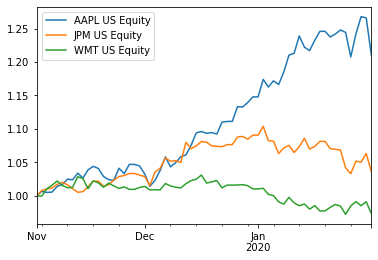

In [13]:
(price_history/price_history.iloc[0]).plot()

From above plot, we can observe that AAPL showed a notable increase in its price while JPM showed a little increase and WMT showed a decrease in price. Could it be because of this direction in the underlying stock price that the PnL showed different signs?

If that is the case, we should observe opposite signs in the PnL if we reverse the time-series of underlying stock prices. However, when we run the dynamic delta hedging strategy for the reversed time-series, we see PnLs with same signs. The results are given below.

This proves that PnL from dynamic delta hedging strategy has nothing to do with the direction of the underlying stock prices.

In [14]:
price_history_reversed=price_history.sort_index(ascending=False)
price_history_reversed.index=price_history.index
pnl_simplified_reversed={}

In [15]:
for ticker in tickers:
    df, pnl_simplified_reversed[ticker], _ = \
    simplified_dynamic_delta_hedge(price_history_df=price_history[ticker], num_opt=100, K=price_history[ticker].iloc[0], r=0.02,\
                                   v=data[ticker]['Volatility'], q=data[ticker]['Dividend'], opt_type='Call', instrument_delta=1, target_delta=0)

In [16]:
pnl_simplified_reversed

{'AAPL US Equity': 1145.4999401391124,
 'JPM US Equity': -240.0066341694457,
 'WMT US Equity': -281.25199205139234}

Instead, it is important to note that our strategy only makes delta neutral. Dynamic delta hedging strategy can work as long as the daily changes in stock prices are small. If there is a large change in the underlying stock prices, a simple delta hedging would not have been enough, and we would need a delta-gamma hedging which would involve trading other options or futures. Therefore, one can say that dynamic delta hedging strategy is similar to betting on the volatility. If the volatility increases beyond expectation during the option holding period, we can expect a positive PnL and vice versa.

In order to check how the volatilities of each underlying stock have changed over the holding period, we can look at the 10-day realized volatilities. The plot is shown below. We can observe that AAPL showed significant increase in volatility over the option holding period. WMT showed a decrease in the volatility. These explain why AAPL showed positive PnL and WMT showed negative PnL.

In [17]:
return_history=price_history.pct_change()

In [18]:
realized_vol_history=pd.DataFrame(columns=tickers, index=return_history.index)
squared_return_history=return_history**2
for i in range(10, realized_vol_history.shape[0]):
    realized_vol_history.iloc[i]=squared_return_history.iloc[i-10:i].sum()**0.5 *np.sqrt(252/10)

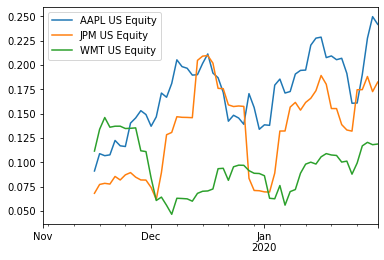

In [19]:
realized_vol_history.plot()

However, why is JPM still showing a negative PnL although the volatility has increased over time? Before we answer this question, we need to see what happens to the PnLs if there is no price change in the underlying stocks. From the analysis below, we can see that the PnLs all become negative, and the degree of negativeness in JPM and WMT becomes worse.

This implies that there is another force dragging the PnL down. The reason why we have a negative starting point in the PnL is because of the diminishing time values in options. Note that we held the entire options we purchased until the options expire. In November, the option values included time values in addition to their intrinsic values, but as the maturity approached, these time values all faded away. We cannot hedge against theta because we cannot stop the clock from running. It is like a form of carry. The reason why JPM still showed negative PnL is because the gains from rising volatility was not enough to offset the loss from diminishing time values of options.

In [20]:
price_history_constant=price_history.copy()
for ticker in tickers:
    price_history_constant[ticker]=price_history[ticker].iloc[0]
    pnl_simplified_constant={}

In [21]:
for ticker in tickers:
    df, pnl_simplified_constant[ticker], _ = \
    simplified_dynamic_delta_hedge(price_history_df=price_history_constant[ticker], num_opt=100, K=price_history_constant[ticker].iloc[0], r=0.02,\
                                   v=data[ticker]['Volatility'], q=data[ticker]['Dividend'], opt_type='Call', instrument_delta=1, target_delta=0)

In [22]:
pnl_simplified_constant

{'AAPL US Equity': -1272.7583050506419,
 'JPM US Equity': -466.4553388236909,
 'WMT US Equity': -446.21523081840496}

In this simplified dynamic delta hedging, we did not consider the overnight interest on cash balance. This could have also caused our PnLs to show worse than they would have been theoretically. However, as we will see in the next section, the overnight interest on cash balance does not make significant changes in PnL.

# 5. If there’s a 0.05% trading cost on shares, 1% trading cost on option, 2% interest overnight on cash in the account, and cannot trade partial shares (minimum unit of 1 share), what will be the pnl?

In [23]:
def constrained_dynamic_delta_hedge(price_history_df, num_opt, K, r, v, q, opt_type, tc_stock, tc_opt, overnight_interest, partial_share=False, instrument_delta=1, target_delta=0):
    
    # create a dateframe of delta hedge
    dynamic_delta_hedge_df=pd.DataFrame(index=price_history_df.index,\
                                        columns=['New Stock Price', 'New Option Delta', 'Current Option Position',\
                                                 'New Stock Delta', 'Current Stock Position',\
                                                 'Portfolio Delta Before Hedge', 'Target Portfolio Delta',\
                                                 'Required Change in Stock Position', 'Cash Balance'])
    dynamic_delta_hedge_df['New Stock Price']=price_history_df
    dynamic_delta_hedge_df['Current Option Position']=num_opt
    dynamic_delta_hedge_df['New Stock Delta']=instrument_delta
    dynamic_delta_hedge_df['Target Portfolio Delta']=target_delta
    
    # calculate initial option price
    initial_day=price_history.index[0]
    maturity_day=price_history.index[-1]
    opt_price=vanilla_opt(S=price_history_df.iloc[0], K=K, T=(maturity_day-initial_day).days/365, r=r, v=v, q=q, opt_type=opt_type)
    
    # create a dummy row for initialization
    dummy_day=initial_day-timedelta(days=1)
    dynamic_delta_hedge_df.loc[dummy_day, ['Current Stock Position', 'Required Change in Stock Position']]=0
    dynamic_delta_hedge_df.loc[dummy_day, 'Cash Balance']=-opt_price*num_opt*(1+tc_opt)/(1+1/360*overnight_interest)
    
    # conduct delta hedge
    for day in price_history_df.index:
        previous_day=dynamic_delta_hedge_df.index[list(price_history_df.index).index(day)-1]
        
        dynamic_delta_hedge_df.loc[day, 'New Option Delta']=\
        vanilla_delta(S=dynamic_delta_hedge_df.loc[day, 'New Stock Price'], K=K, T=(maturity_day-day).days/365, r=r, v=v, q=q, opt_type=opt_type)
        
        dynamic_delta_hedge_df.loc[day, 'Current Stock Position']=\
        dynamic_delta_hedge_df.loc[previous_day, 'Current Stock Position']+dynamic_delta_hedge_df.loc[previous_day, 'Required Change in Stock Position']
        
        dynamic_delta_hedge_df.loc[day, 'Portfolio Delta Before Hedge']=\
        dynamic_delta_hedge_df.loc[day, 'New Option Delta']*dynamic_delta_hedge_df.loc[day, 'Current Option Position']\
        +dynamic_delta_hedge_df.loc[day, 'New Stock Delta']*dynamic_delta_hedge_df.loc[day, 'Current Stock Position']
        
        if day == maturity_day:
            dynamic_delta_hedge_df.loc[day, 'Target Portfolio Delta']=dynamic_delta_hedge_df.loc[day, 'Portfolio Delta Before Hedge']
        
        dynamic_delta_hedge_df.loc[day, 'Required Change in Stock Position']=\
        (dynamic_delta_hedge_df.loc[day, 'Target Portfolio Delta']-dynamic_delta_hedge_df.loc[day, 'Portfolio Delta Before Hedge'])\
        /dynamic_delta_hedge_df.loc[day, 'New Stock Delta']
        
        if partial_share==False:
            dynamic_delta_hedge_df.loc[day, 'Required Change in Stock Position']=round(dynamic_delta_hedge_df.loc[day, 'Required Change in Stock Position'])
        
        dynamic_delta_hedge_df.loc[day, 'Cash Balance']=\
        dynamic_delta_hedge_df.loc[previous_day, 'Cash Balance']*(1+((day-previous_day).days)/360*overnight_interest)\
        -dynamic_delta_hedge_df.loc[day, 'Required Change in Stock Position']*dynamic_delta_hedge_df.loc[day, 'New Stock Price']\
        *(1+tc_stock*np.sign(dynamic_delta_hedge_df.loc[day, 'Required Change in Stock Position']))
        
    # delete the dummy row
    dynamic_delta_hedge_df=dynamic_delta_hedge_df.drop(index=dummy_day)
    
    # execute right
    if opt_type=='Call':
        execution=max(price_history_df.iloc[-1]-K, 0)
    elif opt_type=='Put':
        execution=max(K-price_history_df.iloc[-1], 0)
    else:
        print('Option type is incorrect.')
    
    # calculate pnl
    pnl=\
    dynamic_delta_hedge_df.loc[maturity_day, 'Current Stock Position']*dynamic_delta_hedge_df.loc[maturity_day, 'New Stock Price']\
    *(1-tc_stock*np.sign(dynamic_delta_hedge_df.loc[maturity_day, 'Current Stock Position']))\
    +dynamic_delta_hedge_df.loc[maturity_day, 'Cash Balance']+execution*num_opt
    
    return dynamic_delta_hedge_df, pnl, opt_price

In [24]:
pnl_constrained={}
opt_price={}

In [25]:
for ticker in tickers:
    df, pnl_constrained[ticker], _ = \
    constrained_dynamic_delta_hedge(price_history_df=price_history[ticker], num_opt=100, K=price_history[ticker].iloc[0], r=0.02,\
                                    v=data[ticker]['Volatility'], q=data[ticker]['Dividend'], opt_type='Call',\
                                    tc_stock=0.0005, tc_opt=0.01, overnight_interest=0.02, partial_share=False, instrument_delta=1, target_delta=0)
    print(ticker)
    display(df)
    print('\n')

AAPL US Equity


,New Stock Price,New Option Delta,Current Option Position,New Stock Delta,Current Stock Position,Portfolio Delta Before Hedge,Target Portfolio Delta,Required Change in Stock Position,Cash Balance
2019-11-01,255.82,0.506845,100.0,1.0,0,50.6845,0.0,-51,11754.810702
2019-11-04,257.50,0.511709,100.0,1.0,-51,0.170904,0.0,0,11756.769837
2019-11-05,257.13,0.510423,100.0,1.0,-51,0.042274,0.0,0,11757.422991
2019-11-06,257.24,0.510621,100.0,1.0,-51,0.062052,0.0,0,11758.076181
2019-11-07,259.43,0.517121,100.0,1.0,-51,0.712104,0.0,-1,12018.029693
...,...,...,...,...,...,...,...,...,...
2020-01-27,308.95,0.532148,100.0,1.0,-55,-1.785154,0.0,2,12219.107955
2020-01-28,317.69,0.531946,100.0,1.0,-53,0.194621,0.0,0,12219.786794
2020-01-29,324.34,0.528578,100.0,1.0,-53,-0.142198,0.0,0,12220.465671
2020-01-30,323.87,0.52009,100.0,1.0,-53,-0.991015,0.0,1,11897.112651




JPM US Equity


,New Stock Price,New Option Delta,Current Option Position,New Stock Delta,Current Stock Position,Portfolio Delta Before Hedge,Target Portfolio Delta,Required Change in Stock Position,Cash Balance
2019-11-01,127.80,0.500204,100.0,1.0,0,50.020407,0.0,-50,5915.685108
2019-11-04,128.82,0.508398,100.0,1.0,-50,0.839814,0.0,-1,6045.426645
2019-11-05,129.10,0.510573,100.0,1.0,-51,0.057334,0.0,0,6045.762502
2019-11-06,129.30,0.512083,100.0,1.0,-51,0.208324,0.0,0,6046.098378
2019-11-07,130.00,0.517502,100.0,1.0,-51,0.750162,0.0,-1,6176.369272
...,...,...,...,...,...,...,...,...,...
2020-01-27,132.03,0.507144,100.0,1.0,-51,-0.285576,0.0,0,6077.569932
2020-01-28,134.43,0.50967,100.0,1.0,-51,-0.032966,0.0,0,6077.907575
2020-01-29,134.23,0.507672,100.0,1.0,-51,-0.232784,0.0,0,6078.245237
2020-01-30,135.89,0.506804,100.0,1.0,-51,-0.31955,0.0,0,6078.582917




WMT US Equity


,New Stock Price,New Option Delta,Current Option Position,New Stock Delta,Current Stock Position,Portfolio Delta Before Hedge,Target Portfolio Delta,Required Change in Stock Position,Cash Balance
2019-11-01,117.62,0.503171,100.0,1.0,0,50.317114,0.0,-50,5427.382117
2019-11-04,117.57,0.502545,100.0,1.0,-50,0.254475,0.0,0,5428.286681
2019-11-05,118.86,0.513621,100.0,1.0,-50,1.362075,0.0,-1,5547.388822
2019-11-06,119.50,0.518943,100.0,1.0,-51,0.894262,0.0,-1,5667.13726
2019-11-07,120.23,0.524923,100.0,1.0,-52,0.492309,0.0,0,5667.452101
...,...,...,...,...,...,...,...,...,...
2020-01-27,115.86,0.49664,100.0,1.0,-49,0.664037,0.0,-1,5464.770379
2020-01-28,116.60,0.498302,100.0,1.0,-50,-0.16975,0.0,0,5465.073977
2020-01-29,115.89,0.497667,100.0,1.0,-50,-0.233326,0.0,0,5465.377592
2020-01-30,116.58,0.499006,100.0,1.0,-50,-0.099383,0.0,0,5465.681224


In [26]:
pnl_constrained

{'AAPL US Equity': 1164.2063418236921,
 'JPM US Equity': -218.81456388313853,
 'WMT US Equity': -261.37737662854306}

While the transaction costs give negative impact on the PnLs, the overnight interest rate applied to the cash balance exceeded these negative effects, slightly improving the PnLs.